In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('/kaggle/input/tbi-dataset/filledata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   102 non-null    int64  
 1   Sex                   102 non-null    int64  
 2   Marshall (t0)         102 non-null    float64
 3   Entry Diagnosis (t0)  102 non-null    int64  
 4   CRS-R (t1)            102 non-null    int64  
 5   RLAS (t1)             102 non-null    int64  
 6   DRS (t1)              102 non-null    int64  
 7   ERBI A (t1)           102 non-null    int64  
 8   ERBI B (t1)           102 non-null    int64  
 9   GOS-E (t1)            102 non-null    int64  
 10  CRS-R (t2)            102 non-null    float64
 11  RLAS (t2)             102 non-null    float64
 12  DRS (t2)              102 non-null    float64
 13  ERBI A (t2)           102 non-null    float64
 14  ERBI B (t2)           102 non-null    float64
 15  GOS-E (t2)            1

# Models

In [3]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

# Danh sách các mô hình phân loại
models = [
    ("SVM (RBF)", SVC(kernel='rbf')),
    ("KNN (k=5)", KNeighborsClassifier(n_neighbors=5, metric='euclidean')),
    ("Naive Bayes", GaussianNB()),
    ("Decision Tree (max_depth=10)", DecisionTreeClassifier(max_depth=10, criterion='gini'))
]

In [4]:
X = df.drop(['GOS-E (t2)', 'GOS-E (t1)', 'CRS-R (t2)', 'RLAS (t2)', 'DRS (t2)', 'ERBI A (t2)', 'ERBI B (t2)'], axis=1)
y = df['GOS-E (t2)']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [5]:
# train_distribution = y_train.value_counts(normalize=True)
# test_distribution = y_test.value_counts(normalize=True)

# print("y_train distribution:")
# print(train_distribution)
# print("\ny_test distribution:")
# print(test_distribution)

In [6]:
X

,Age,Sex,Marshall (t0),Entry Diagnosis (t0),CRS-R (t1),RLAS (t1),DRS (t1),ERBI A (t1),ERBI B (t1)
0,76,1,5.0,2,10,3,18,-175,0
1,28,1,3.0,2,8,3,20,-125,0
2,20,0,2.0,2,9,3,18,-175,0
3,22,1,2.0,3,23,4,15,-175,0
4,62,1,2.0,3,23,4,15,-100,5
...,...,...,...,...,...,...,...,...,...
97,19,0,2.0,3,23,7,13,-50,0
98,86,1,5.0,3,23,5,18,-100,0
99,76,1,2.0,3,23,6,18,0,0
100,22,1,5.0,3,23,7,8,0,10


# Minimum Redundancy Maximum Relevance (MRMR)

In [7]:
!pip install mrmr-selection
from mrmr import mrmr_classif

In [8]:
def select_features_mrmr(X, y, k):
    return mrmr_classif(X=X, y=y, K=k)

In [9]:
# Function to evaluate models with 10-fold cross-validation
def evaluate_model_cv(model, X, y, selected_features):
    X_selected = X[selected_features]
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X_selected, y, cv=StratifiedKFold(n_splits=10), scoring=scoring)

In [10]:
# Function to summarize cross-validation results
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [11]:
# Main script
def results_mrmr(models, X, y):
    results_list = []
    
    for k in range(1, 10):
        selected_features = select_features_mrmr(X, y, k)
        
        for model_name, model in models:
            cv_results = evaluate_model_cv(model, X, y, selected_features)
            summary = summarize_cv_results(cv_results)
            
            results_list.append({
                "Model": model_name,
                "K": k,
                **summary
            })
    
    return pd.DataFrame(results_list)

In [12]:
# Function to plot feature importances
def plot_mrmr_feature_importances(X, y, k=9):
    selected_features = select_features_mrmr(X, y, k)
    
    total = sum(range(1, k+1))
    importances = [(k - i) / total * 100 for i in range(k)]
    
    feature_importances = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    })
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(feature_importances['Feature'], feature_importances['Importance'])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    plt.xlabel('Predictor rank')
    plt.ylabel('Predictor importance score (%)')
    plt.title('Minimum Redundancy Maximum Relevance (MRMR) algorithm - 2 classes')
    plt.xticks(rotation=45, ha='right')
    plt.axvline(x=2.5, color='red', linestyle='--')
    plt.ylim(0, max(importances) * 1.1)
    plt.tight_layout()
    plt.show()


In [13]:
results_mrmr = results_mrmr(models, X, y)

100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


In [14]:
results_mrmr

,Model,K,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,SVM (RBF),1,0.712727,0.712727,0.748889,0.712727,0.739286,0.712727,0.701145
1,KNN (k=5),1,0.666364,0.666364,0.632612,0.666364,0.658929,0.666364,0.605453
2,Naive Bayes,1,0.712727,0.712727,0.748889,0.712727,0.739286,0.712727,0.701145
3,Decision Tree (max_depth=10),1,0.712727,0.712727,0.746865,0.712727,0.738095,0.712727,0.699798
4,SVM (RBF),2,0.832727,0.832727,0.858214,0.832727,0.813690,0.832727,0.817536
5,KNN (k=5),2,0.803636,0.803636,0.821548,0.803636,0.781548,0.803636,0.782252
6,Naive Bayes,2,0.811818,0.811818,0.823452,0.811818,0.810714,0.811818,0.800762
7,Decision Tree (max_depth=10),2,0.753636,0.753636,0.748849,0.753636,0.717857,0.753636,0.705247
8,SVM (RBF),3,0.833636,0.833636,0.850179,0.833636,0.819048,0.833636,0.821189
9,KNN (k=5),3,0.793636,0.793636,0.808750,0.793636,0.769048,0.793636,0.767600


In [106]:
best_results_mrmr = (results_mrmr.loc[results_mrmr.groupby('Model')['accuracy'].idxmax()]
                .sort_values(by="accuracy", ascending=False)
                .reset_index(drop=True))
best_results_mrmr["Rank"] = best_results_mrmr.index + 1
best_results_mrmr = best_results_mrmr[["Rank", "Model", "K", "accuracy", "precision_micro", "precision_macro", 
                             "recall_micro", "recall_macro", "f1_micro", "f1_macro"]]

pd.set_option('display.float_format', lambda x: '%.4f' % x)
best_results_mrmr

,Rank,Model,K,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,1,SVM (RBF),3,0.8336,0.8336,0.8502,0.8336,0.8190,0.8336,0.8212
1,2,KNN (k=5),4,0.8136,0.8136,0.8433,0.8136,0.7857,0.8136,0.7849
2,3,Naive Bayes,2,0.8118,0.8118,0.8235,0.8118,0.8107,0.8118,0.8008
3,4,Decision Tree (max_depth=10),3,0.7927,0.7927,0.8345,0.7927,0.7720,0.7927,0.7689


100%|██████████| 9/9 [00:01<00:00,  6.94it/s]


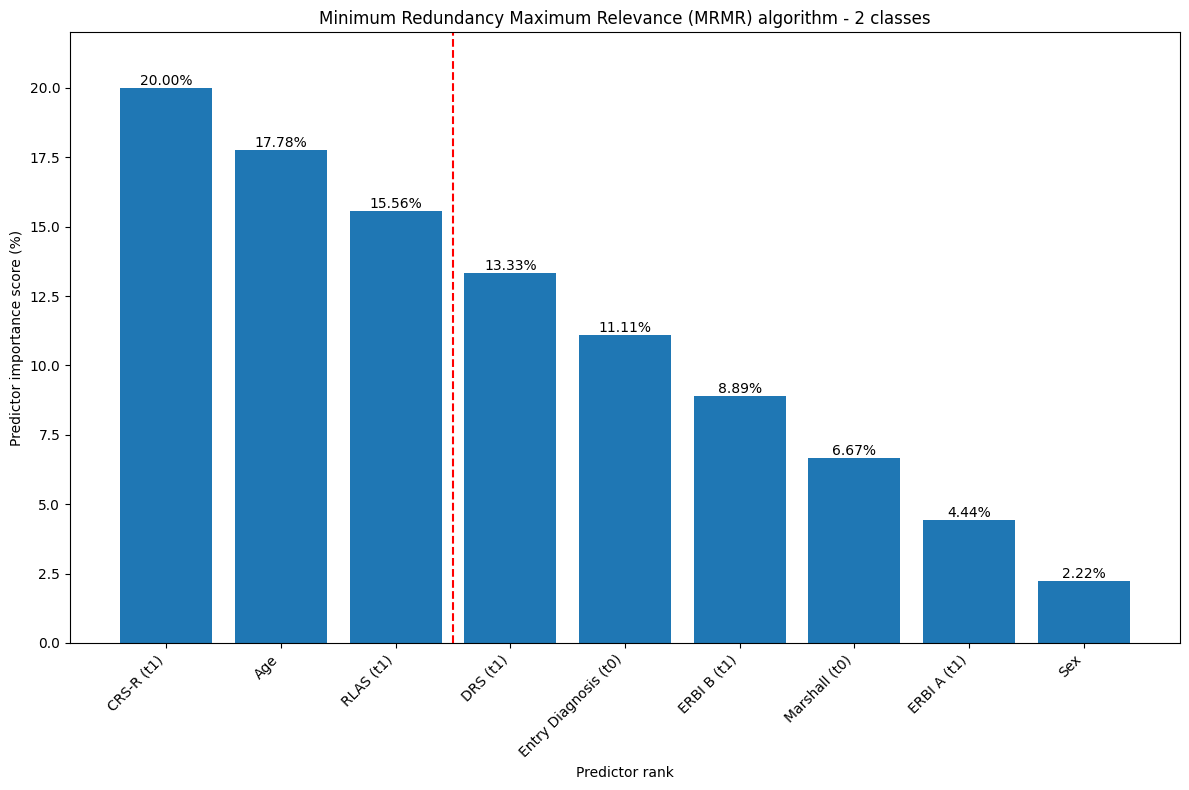

In [16]:
plot_mrmr_feature_importances(X, y)

# Chi-squared Test

In [17]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Function to transform X and y to non-negative values
def transform_data(X, y):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns), y

In [19]:
# Function to select features using chi2
def select_features_chi2(X, y, k):
    # Convert y to categorical if necessary
    y_cat = pd.Categorical(y).codes
    
    # Use SelectKBest with chi2
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y_cat)
    
    # Get selected features
    feature_idx = selector.get_support(indices=True)
    selected_features = X.columns[feature_idx]
    
    return selected_features.tolist()

In [20]:
# Function to evaluate models with 10-fold cross-validation
def evaluate_model_cv(model, X, y, selected_features):
    X_selected = X[selected_features]
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X_selected, y, cv=StratifiedKFold(n_splits=10), scoring=scoring)

In [21]:
# Function to summarize cross-validation results
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [57]:
# Main script
def results_chi2(models, X, y):
    results_list = []
    
    # Transform X and y
    X_transformed, y_transformed = transform_data(X, y)
    
    for k in range(1, 10):
        selected_features = select_features_chi2(X_transformed, y_transformed, k)
        
        for model_name, model in models:
            cv_results = evaluate_model_cv(model, X_transformed, y_transformed, selected_features)
            summary = summarize_cv_results(cv_results)
            
            results_list.append({
                "Model": model_name,
                "K": k,
                **summary
            })
    
    return pd.DataFrame(results_list)

In [58]:
# Function to plot feature importances
def plot_chi2_feature_importances(X, y, k=9):
    y_cat = pd.Categorical(y).codes
    X, _ = transform_data(X, y)
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, y_cat)
    
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    }).sort_values('Score', ascending=False).head(k)
    
    # Convert scores to percentage
    total_score = feature_scores['Score'].sum()
    feature_scores['Importance'] = feature_scores['Score'] / total_score * 100
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(feature_scores['Feature'], feature_scores['Importance'])
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    plt.xlabel('Predictor rank')
    plt.ylabel('Predictor importance score (%)')
    plt.title('Chi-square Feature Selection - 2 classes')
    plt.xticks(rotation=45, ha='right')
    plt.axvline(x=2.5, color='red', linestyle='--')
    plt.ylim(0, max(feature_scores['Importance']) * 1.1)
    plt.tight_layout()
    plt.show()

In [59]:
results_chi2 = results_chi2(models, X, y)

In [60]:
results_chi2

,Model,K,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,SVM (RBF),1,0.7127,0.7127,0.7489,0.7127,0.7393,0.7127,0.7011
1,KNN (k=5),1,0.6855,0.6855,0.6907,0.6855,0.6964,0.6855,0.6494
2,Naive Bayes,1,0.7127,0.7127,0.7489,0.7127,0.7393,0.7127,0.7011
3,Decision Tree (max_depth=10),1,0.7127,0.7127,0.7489,0.7127,0.7393,0.7127,0.7011
4,SVM (RBF),2,0.7127,0.7127,0.7489,0.7127,0.7393,0.7127,0.7011
5,KNN (k=5),2,0.6955,0.6955,0.6999,0.6955,0.7048,0.6955,0.6589
6,Naive Bayes,2,0.7127,0.7127,0.7489,0.7127,0.7393,0.7127,0.7011
7,Decision Tree (max_depth=10),2,0.7127,0.7127,0.7469,0.7127,0.7381,0.7127,0.6998
8,SVM (RBF),3,0.8236,0.8236,0.8394,0.8236,0.8012,0.8236,0.8061
9,KNN (k=5),3,0.7936,0.7936,0.8088,0.7936,0.7690,0.7936,0.7676


In [105]:
best_results_chi2 = (results_chi2.loc[results_chi2.groupby('Model')['accuracy'].idxmax()]
                .sort_values(by="accuracy", ascending=False)
                .reset_index(drop=True))
best_results_chi2["Rank"] = best_results_chi2.index + 1
best_results_chi2 = best_results_chi2[["Rank", "Model", "K", "accuracy", "precision_micro", "precision_macro", 
                             "recall_micro", "recall_macro", "f1_micro", "f1_macro"]]
pd.set_option('display.float_format', lambda x: '%.4f' % x)
best_results_chi2

,Rank,Model,K,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,1,KNN (k=5),8,0.8518,0.8518,0.8698,0.8518,0.8292,0.8518,0.8367
1,2,SVM (RBF),5,0.8427,0.8427,0.8679,0.8427,0.8262,0.8427,0.8281
2,3,Naive Bayes,4,0.8227,0.8227,0.8274,0.8227,0.8202,0.8227,0.8094
3,4,Decision Tree (max_depth=10),5,0.8127,0.8127,0.8560,0.8127,0.7970,0.8127,0.7914


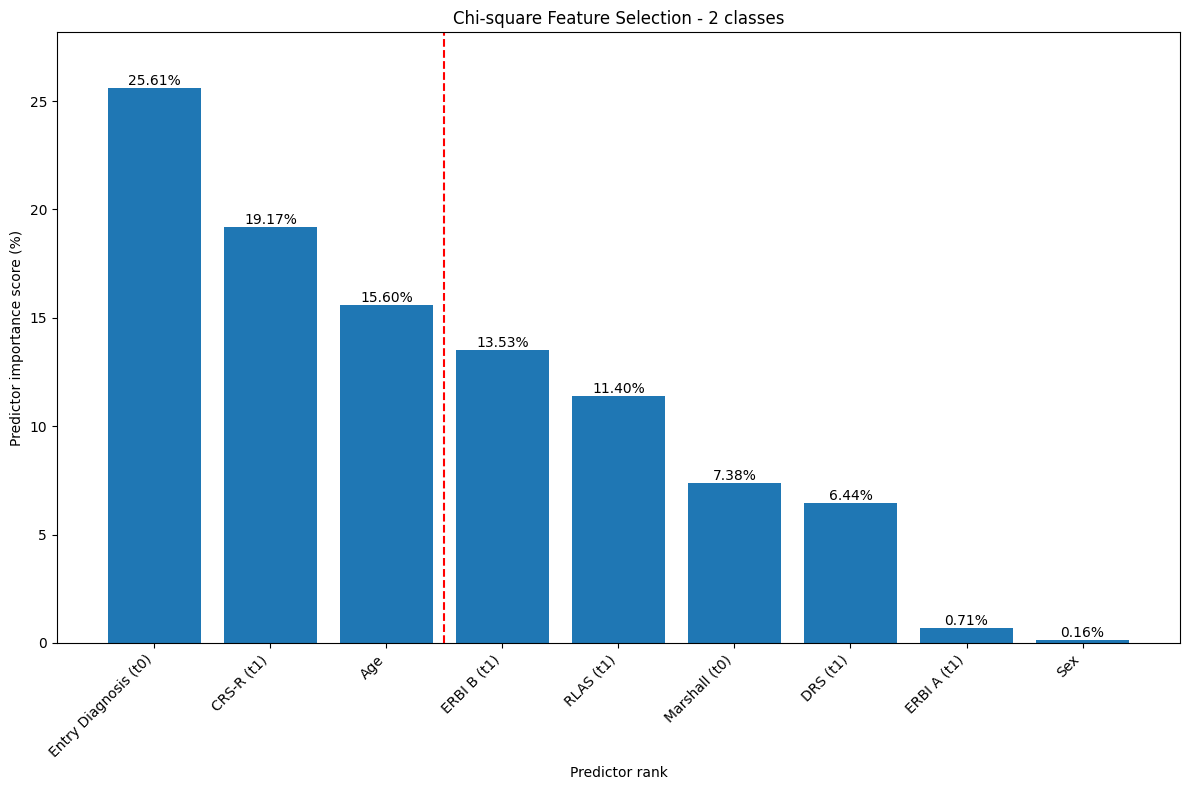

In [62]:
plot_chi2_feature_importances(X, y)

# Pearson Correlation

In [107]:
def select_features_pearson(X, threshold):
    col_corr = set()
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    selected_features = [col for col in X.columns if col not in col_corr]
    return selected_features

In [108]:
# Function to evaluate models with 10-fold cross-validation
def evaluate_model_cv(model, X, y, selected_features):
    X_selected = X[selected_features]
    scoring = {
        'accuracy': 'accuracy',
        'precision_micro': make_scorer(precision_score, average='micro'),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_micro': make_scorer(recall_score, average='micro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_micro': make_scorer(f1_score, average='micro'),
        'f1_macro': make_scorer(f1_score, average='macro')
    }
    return cross_validate(model, X_selected, y, cv=StratifiedKFold(n_splits=10), scoring=scoring)

In [109]:
# Function to summarize cross-validation results
def summarize_cv_results(cv_results):
    return {metric: np.mean(cv_results[f'test_{metric}']) for metric in 
            ['accuracy', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro']}

In [110]:
# Main script
def results_pearson(models, X, y, thresholds):
    results_list = []
    
    for threshold in thresholds:
        selected_features = select_features_pearson(X, threshold)
        
        for model_name, model in models:
            if len(selected_features) > 0:
                cv_results = evaluate_model_cv(model, X, y, selected_features)
                summary = summarize_cv_results(cv_results)
                
                results_list.append({
                    "Model": model_name,
                    "Threshold": threshold,
                    "Selected Features": len(selected_features),
                    **summary
                })
    
    return pd.DataFrame(results_list)

In [111]:
def plot_pearson_feature_importances(X, threshold):
    selected_features = select_features_pearson(X, threshold)
    
    correlation_matrix = X[selected_features].corr()
    feature_scores = correlation_matrix.abs().mean(axis=1).sort_values(ascending=False)
    
    total_score = feature_scores.sum()
    feature_scores_percent = feature_scores / total_score * 100
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(feature_scores_percent.index, feature_scores_percent)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    
    plt.xlabel('Features')
    plt.ylabel('Feature Importance (%)')
    plt.title('Pearson Correlation Feature Importance')
    plt.xticks(rotation=45, ha='right')
    plt.axvline(x=2.5, color='red', linestyle='--')
    plt.ylim(0, 20)
    plt.tight_layout()
    plt.show()


In [112]:
thresholds = [0.1, 0.2, 0.3, 0.5, 0.6, 0.9, 1.0]

In [113]:
results_pearson = results_pearson(models, X, y, thresholds)

In [114]:
results_pearson

,Model,Threshold,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,SVM (RBF),0.1000,2,0.7273,0.7273,0.7551,0.7273,0.7304,0.7273,0.7150
1,KNN (k=5),0.1000,2,0.7073,0.7073,0.6892,0.7073,0.6833,0.7073,0.6576
2,Naive Bayes,0.1000,2,0.7182,0.7182,0.7431,0.7182,0.7137,0.7182,0.7013
3,Decision Tree (max_depth=10),0.1000,2,0.6673,0.6673,0.6503,0.6673,0.6155,0.6673,0.6019
4,SVM (RBF),0.2000,3,0.7173,0.7173,0.7443,0.7173,0.7179,0.7173,0.7042
5,KNN (k=5),0.2000,3,0.7764,0.7764,0.7933,0.7764,0.7613,0.7764,0.7540
6,Naive Bayes,0.2000,3,0.7091,0.7091,0.7235,0.7091,0.6940,0.7091,0.6859
7,Decision Tree (max_depth=10),0.2000,3,0.7082,0.7082,0.7322,0.7082,0.6845,0.7082,0.6780
8,SVM (RBF),0.3000,3,0.7173,0.7173,0.7443,0.7173,0.7179,0.7173,0.7042
9,KNN (k=5),0.3000,3,0.7764,0.7764,0.7933,0.7764,0.7613,0.7764,0.7540


In [115]:
best_results_pearson = (results_pearson.loc[results_pearson.groupby('Model')['accuracy'].idxmax()]
                .sort_values(by="accuracy", ascending=False)
                .reset_index(drop=True))
best_results_pearson["Rank"] = best_results_pearson.index + 1
best_results_pearson = best_results_pearson[["Rank", "Model", "Threshold", "Selected Features", 
                             "accuracy", "precision_micro", "precision_macro", 
                             "recall_micro", "recall_macro", "f1_micro", "f1_macro"]]
pd.set_option('display.float_format', lambda x: '%.4f' % x)
best_results_pearson

,Rank,Model,Threshold,Selected Features,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,1,Naive Bayes,0.9000,8,0.7836,0.7836,0.8210,0.7836,0.7607,0.7836,0.7506
1,2,KNN (k=5),0.2000,3,0.7764,0.7764,0.7933,0.7764,0.7613,0.7764,0.7540
2,3,Decision Tree (max_depth=10),0.5000,6,0.7455,0.7455,0.7415,0.7455,0.7351,0.7455,0.7078
3,4,SVM (RBF),0.1000,2,0.7273,0.7273,0.7551,0.7273,0.7304,0.7273,0.7150


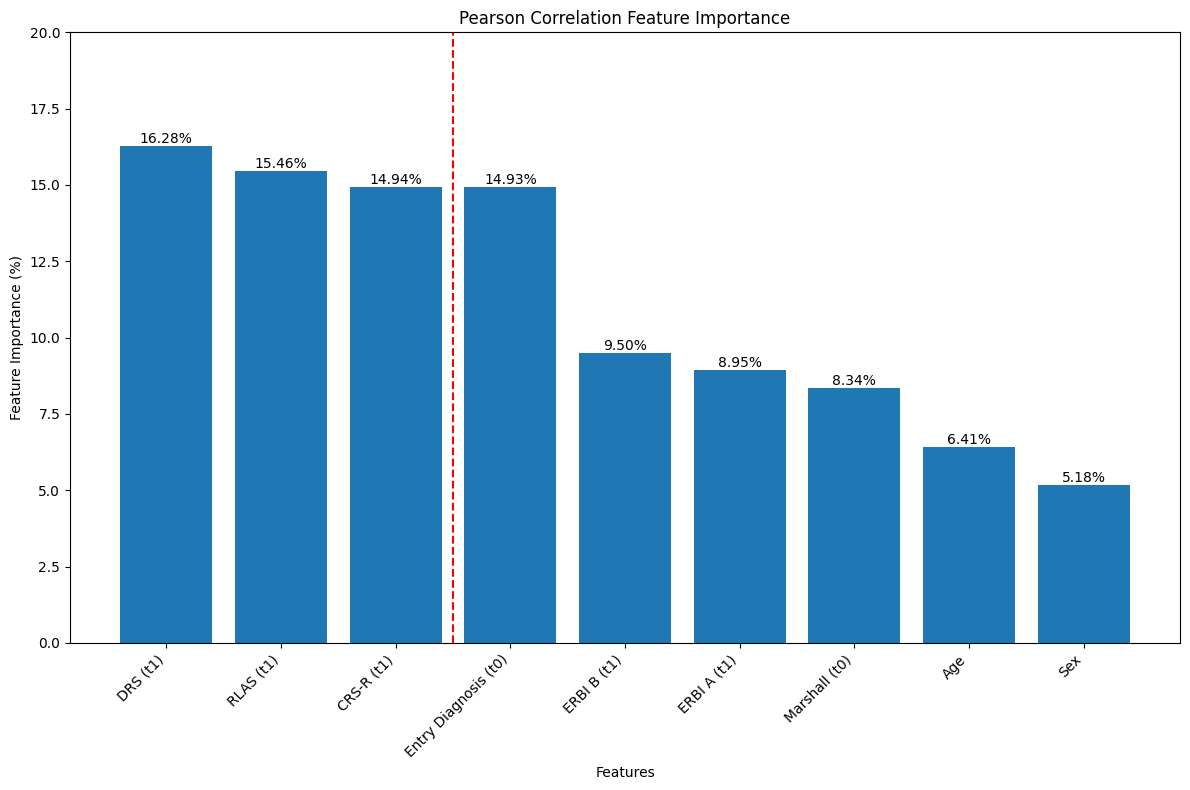

In [116]:
plot_pearson_feature_importances(X, threshold=1.0)

# Visualization

## 1. MRMR

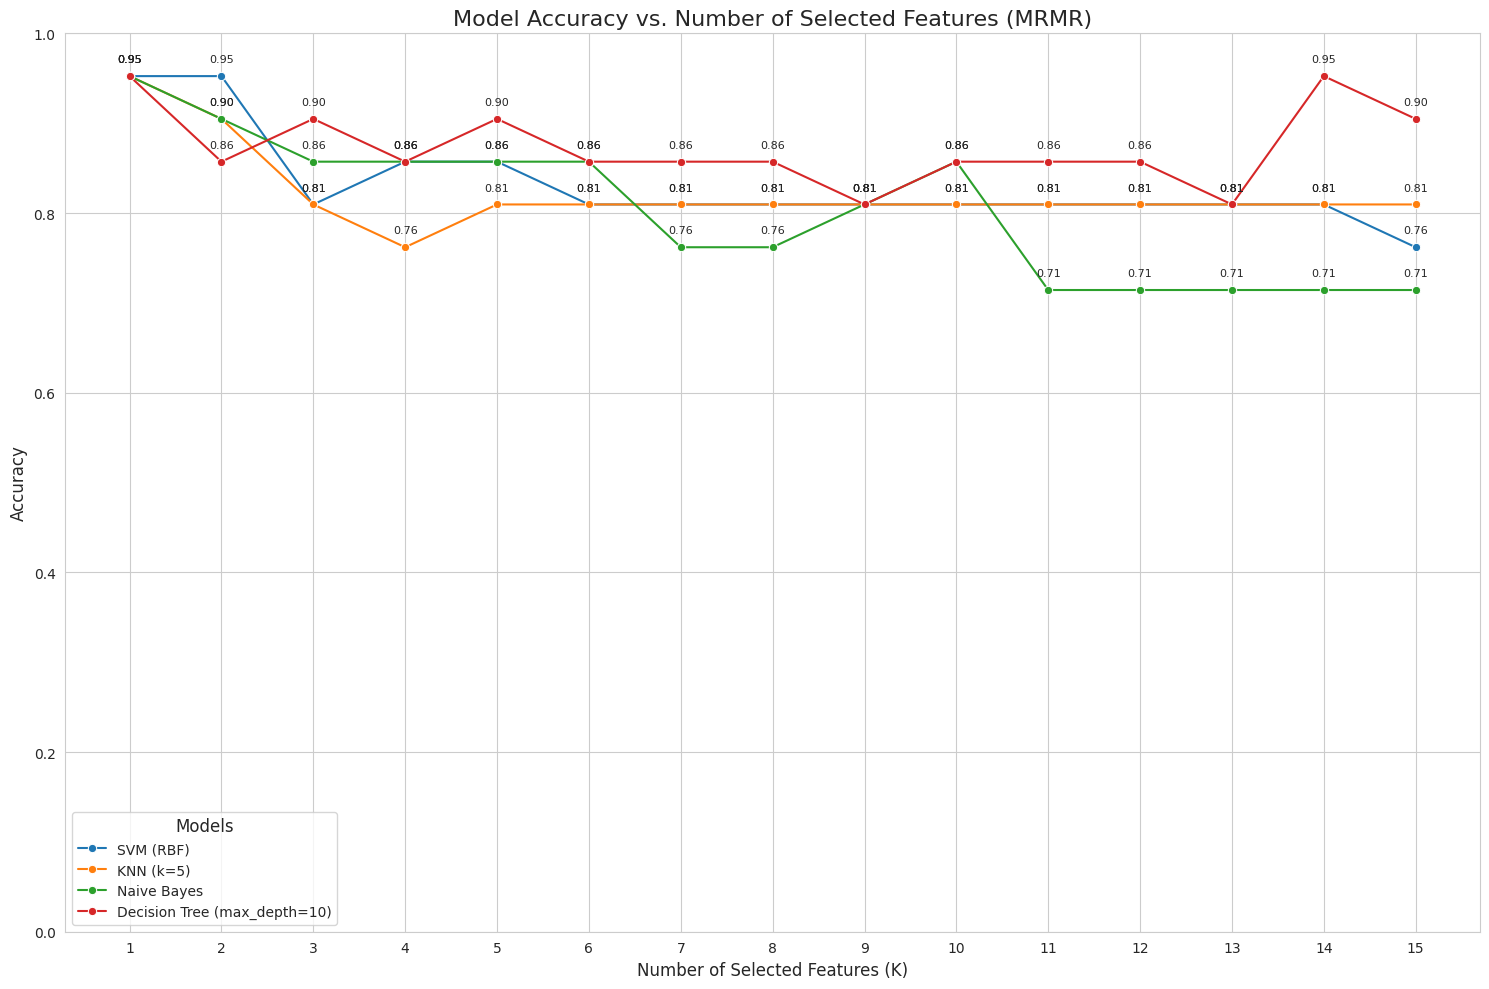

In [20]:
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

for model in results_mrmr['Model'].unique():
    model_data = results_mrmr[results_mrmr['Model'] == model]
    sns.lineplot(x='K', y='Accuracy', data=model_data, marker='o', label=model)

plt.title('Model Accuracy vs. Number of Selected Features (MRMR)', fontsize=16)
plt.xlabel('Number of Selected Features (K)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Models', title_fontsize='12', fontsize='10')
plt.xticks(range(1, 16))
plt.ylim(0, 1)

for model in results_mrmr['Model'].unique():
    model_data = results_mrmr[results_mrmr['Model'] == model]
    for _, row in model_data.iterrows():
        plt.annotate(f"{row['Accuracy']:.2f}", 
                     (row['K'], row['Accuracy']), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center', 
                     fontsize=8)

plt.tight_layout()
plt.show()

## 2. Chi-squared Test

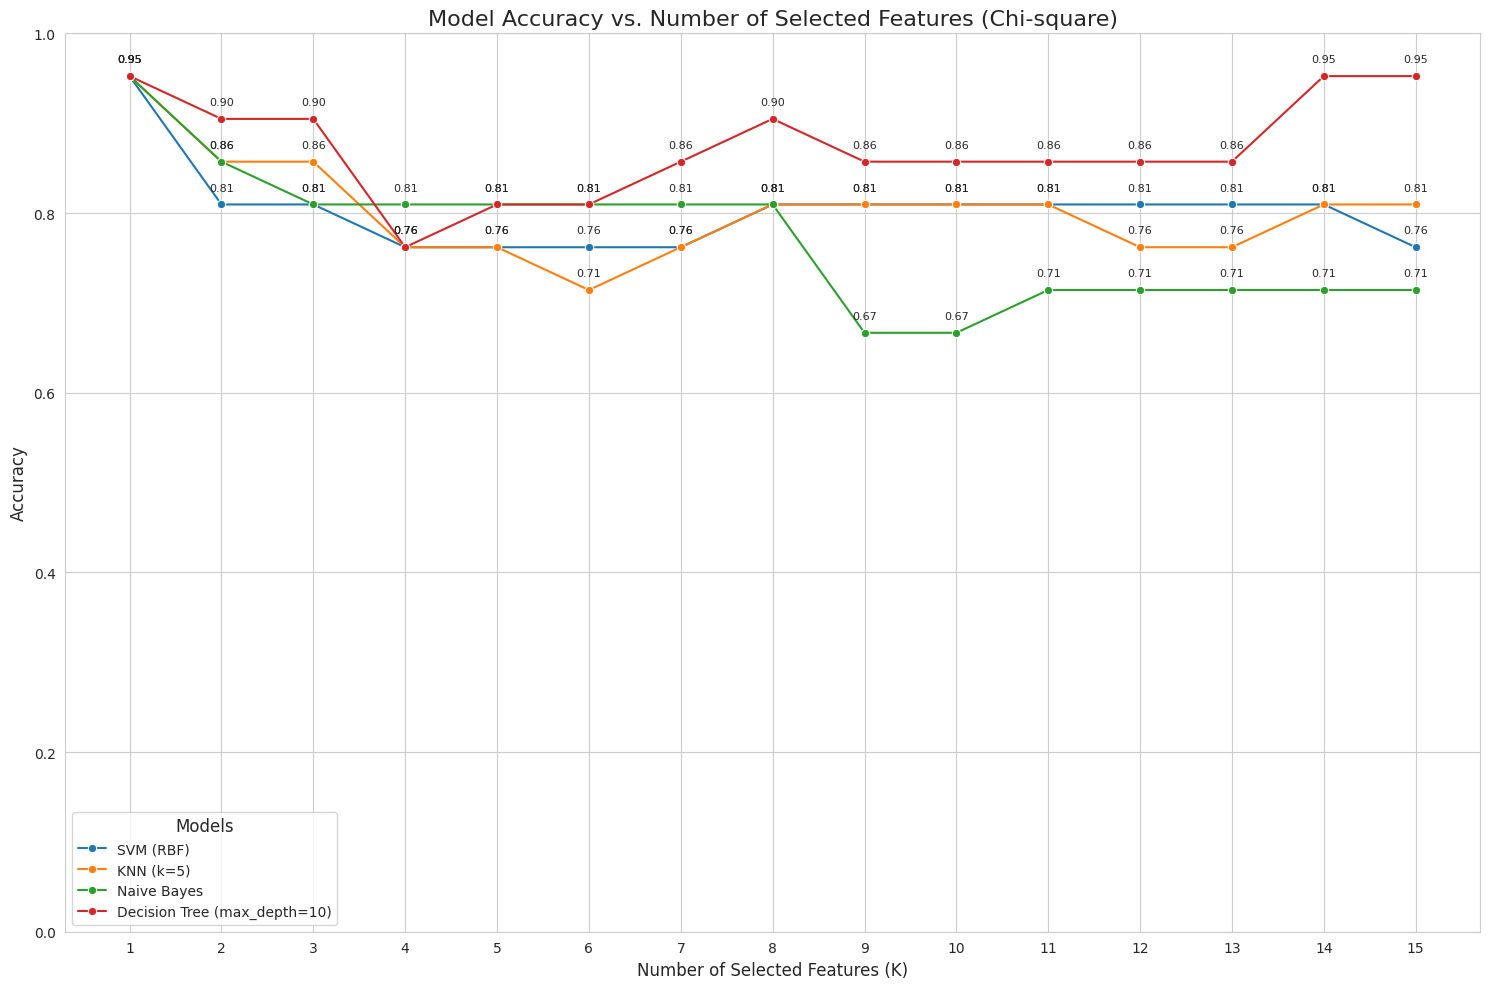

In [21]:
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

for model in results_chi2['Model'].unique():
    model_data = results_chi2[results_chi2['Model'] == model]
    sns.lineplot(x='K', y='Accuracy', data=model_data, marker='o', label=model)

plt.title('Model Accuracy vs. Number of Selected Features (Chi-square)', fontsize=16)
plt.xlabel('Number of Selected Features (K)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Models', title_fontsize='12', fontsize='10')
plt.xticks(range(1, 16))
plt.ylim(0, 1)

for model in results_chi2['Model'].unique():
    model_data = results_chi2[results_chi2['Model'] == model]
    for _, row in model_data.iterrows():
        plt.annotate(f"{row['Accuracy']:.2f}", 
                     (row['K'], row['Accuracy']), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center', 
                     fontsize=8)

plt.tight_layout()
plt.show()


## 3. Pearson Correlation

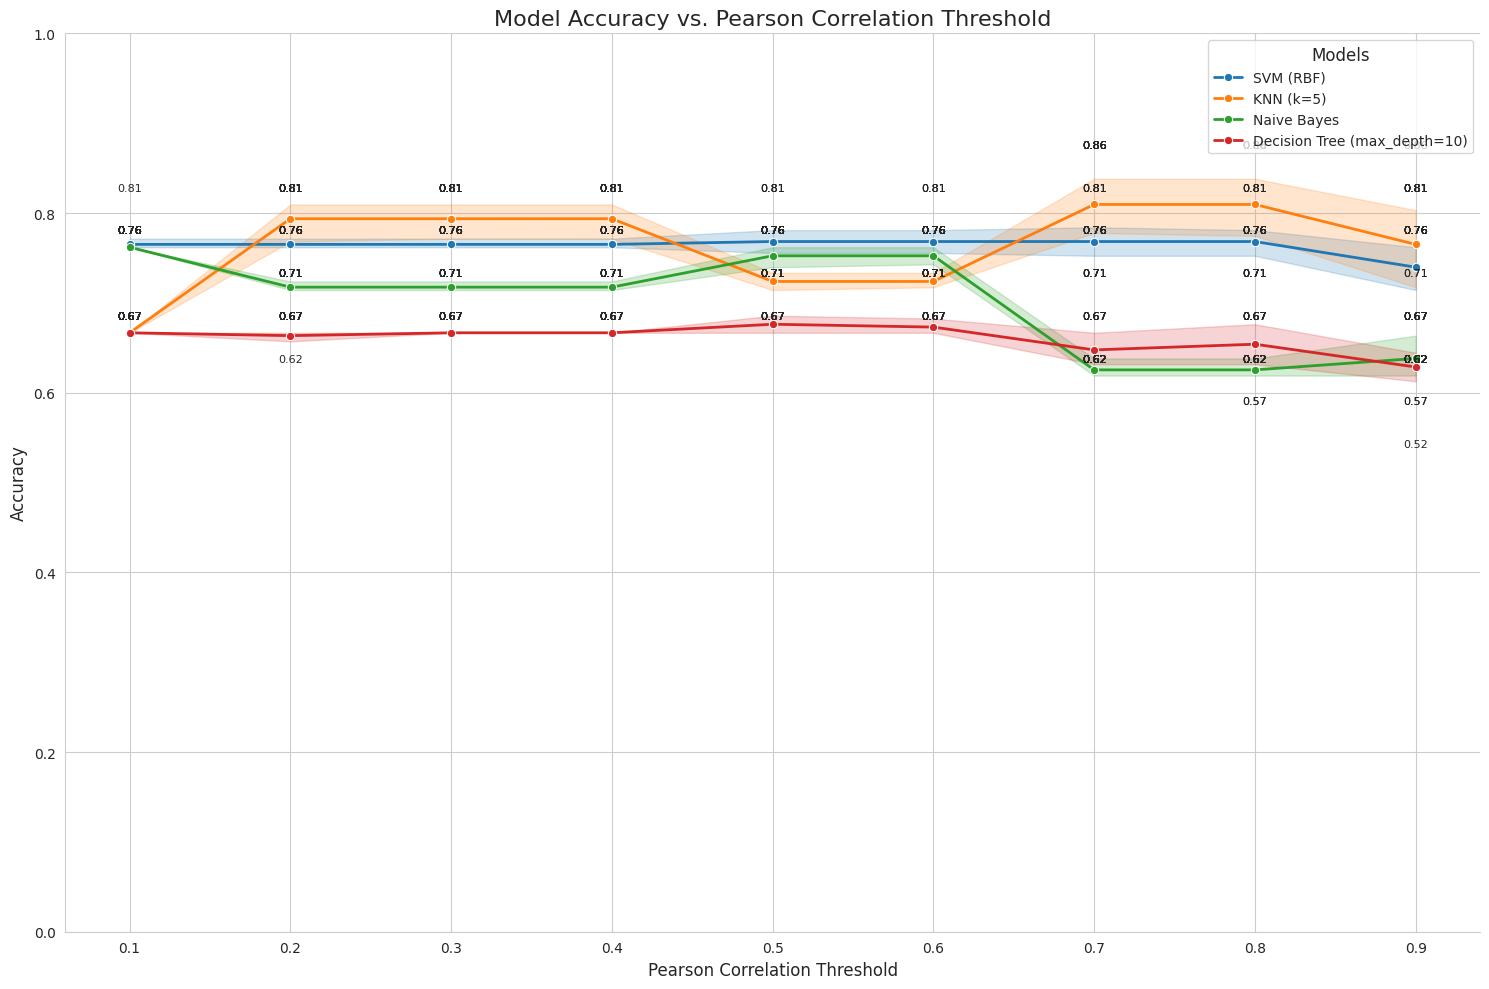

In [28]:
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

for model in results_pearson['Model'].unique():
    model_data = results_pearson[results_pearson['Model'] == model]
    sns.lineplot(x='Threshold', y='Accuracy', data=model_data, marker='o', label=model, linewidth=2)

plt.title('Model Accuracy vs. Pearson Correlation Threshold', fontsize=16)
plt.xlabel('Pearson Correlation Threshold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Models', title_fontsize='12', fontsize='10')
plt.ylim(0, 1)

# Remove spines
sns.despine()

for model in results_pearson['Model'].unique():
    model_data = results_pearson[results_pearson['Model'] == model]
    for _, row in model_data.iterrows():
        plt.annotate(f"{row['Accuracy']:.2f}", 
                     (row['Threshold'], row['Accuracy']), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center', 
                     fontsize=8)

plt.tight_layout()
plt.show()
